In [2]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt
import math as math
import scipy.special as special
import pandas as pd

In [3]:
def Snell(nparray):
    S = np.ones(np.size(nparray))*nparray[-1]
    for i in range(1,np.size(nparray)+1):
        S[-i] = max(nparray[-i],S[-i+1])
    return S

## Evolution du prix d'une option suivant un processus de Poisson

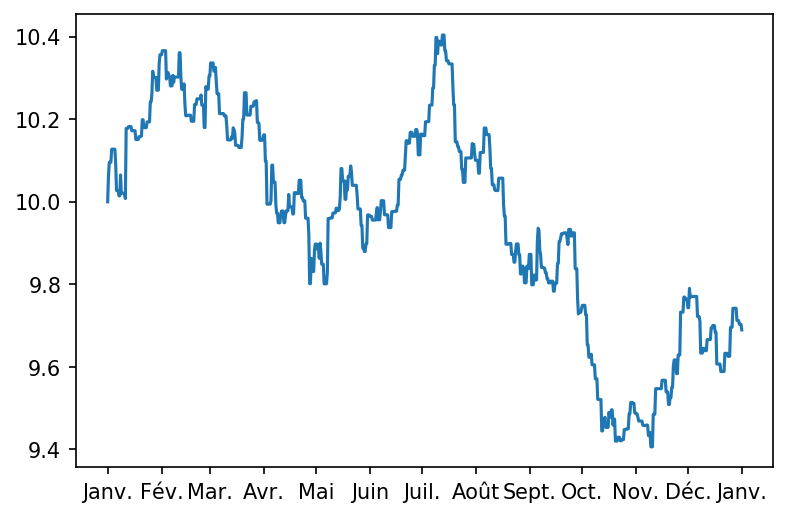

In [55]:
T=365                            #La durée sur laquelle on simule
P0 = 10                          #la valeur initiale de l'option

lam = 2                          # la intensité du processus, la fréquence des variations du prix
sigm = 0.03                      #l'intensité de la variation à un temps donné
P = np.array([P0]) 

        # Création de la simation

    # On crée le Processus nous indiquant les moment de fluctuation du prix de l'option 
Poi = stat.poisson.rvs(mu = lam*T)
Pro_Poi = np.floor((stat.uniform.rvs(size = Poi)*(T+1)))
N = np.sort(Pro_Poi)

    # Création du l'évolution des prix par rapport au temps
for t in range(0,Poi-1):
    P = np.append(P, (N[t+1]-N[t])*stat.norm.rvs(loc =0,scale = sigm)+P[t])


    # Variation du processus au cours du temps 

x= np.linspace(0,T,Poi)

plt.figure(dpi=150)
plt.plot(x,P, label='Prix de $X$')
plt.xticks(np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31]),labels=['Janv.','Fév.', 'Mar.', 'Avr.', 'Mai', 'Juin', 'Juil.', 'Août', 'Sept.', 'Oct.', 'Nov.', 'Déc.','Janv.'])
#plt.legend()
plt.savefig(format='pdf',fname='Evolution.pdf', transparent = True)
plt.show()

# "Pseado Envelope de Snell du processus" 
###
#plt.figure(dpi=150)
#plt.plot(x,P, label='Prix de $X$')
#plt.xticks(np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31]),labels=['Janv.','Fév.', 'Mar.', 'Avr.', 'Mai', 'Juin', 'Juil.', 'Août', 'Sept.', 'Oct.', 'Nov.', 'Déc.','Janv.'])
#plt.plot(x, Snell(P),linestyle = '--',label='$(U_n)$ ',c='red')
#plt.legend()
#plt.savefig(format='pdf',fname='Evolution_plus_pseado_snell.pdf', transparent = True)
#plt.show()
###

# Actifs actualisés ou non  

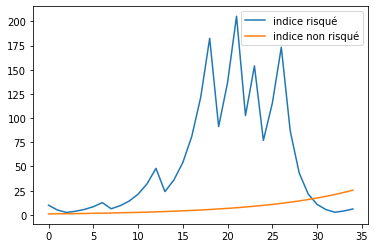

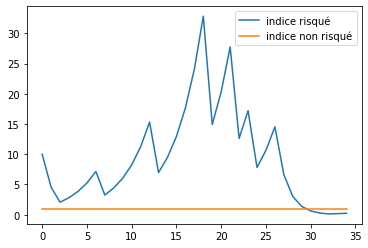

In [5]:
N = 35                 # Durée de simulation 
S0 = 10                # Prix initial de l'actif risque
r = 0.1                # Taux d'interet fixe
proba = 1/2            # La tendance de l'action à monter ou a baisser
b = 0.5                # 1+b est le raports entre deux temps si bénéfices 
a = -0.5               # 1+a est le raports entre deux temps si pertes

S1 = np.array([S0])    # Création de l'actif risqué de valeur initiale S0

for i in range(1,N):
    u = stat.bernoulli.rvs(proba)*(b - a) + a
    S1 = np.append(S1, S1[i-1]*(1+u))
    
X = np.arange(N)

plt.plot(X,S1,label='indice risqué')
plt.plot(X,(1+r)**X, label='indice non risqué')
plt.legend()
plt.savefig(fname='non_actualise.pdf', format="pdf", transparent=True)
plt.show()

plt.plot(X,S1/((1+r)**X), label='indice risqué' )
plt.plot(X,np.ones(N), label='indice non risqué')
plt.legend()
plt.savefig(fname='actualise.pdf', format="pdf", transparent=True)
plt.show()

# Modèle Cox-Rox-Rubinstein 

In [39]:
'''

    Ce code à un but pédagogique, il est orienté objet afin de mettre en avant tout les calculs et un code associé pour
les éléments du mémoire et ce de manière indépendante. Il n'est donc pas optimal en terme de complexité et on remarquera 
que de nombreuses boucles auraient pu (dût) être épargniées si cela n'avait pas été dans cet objectif.

    En programation objet, on définie des classes qui contiennent les fonctions en elle. D'abord, on créer un objet avec 
les paramètres (données) requis et on appelle les fonctions grâce à la commande : " NOM_OBJECT.NOM_FONCTION() ". On peut aussi
appeler des constantes calculer au sein de l'objet avec la commande : " NOM_OBJECT.NOM_CONSTANTE ".

'''


                            # La classe qui regroupe les options du modèle C.R.R

    # Début de la classe mère
    
class option_CRR: 

    def __init__(self, N, S0, K, up, down, intrest, call ):
        
        # Les entrées
        self.N = N                       # échéance
        self.S0 = S0                     # S_0
        self.K = K                       # Prix d'exercice à N
        self.up = up                     # La variation up au temps n+1  S_{n+1} = S_{n}(1+up)
        self.down = down                 # La variation down au temps n+1  S_{n+1} = S_{n}(1+down)
        self.intrest = intrest           # Interet de l'actif sans risque
        self.call = call                 # Type d'option : Call ou Put

        # Les données que l'on calcul
        self.p_up = (self.intrest - self.down)/(self.up - self.down)                    # Proba de up
        self.p_down = 1 -self.p_up                                                      # Proba de down
        (self.arbre_binomial, self.X, self.Y) = self.creation_arbre_binomial()          # Arbre binomial 
        self.arbre_prix = self.creation_arbre_prix()                                    # Arbre des prix
        self.arbre_benefice = self.creation_arbre_benefice()                            # Arbre des bénéfices
        self.arbre_valeur = self.creation_arbre_valeur()                                # Arbre des valeurs
        self.arbre_binaire = self.creation_arbre_binaire()                              # Arbre du moment d'exercice
        (self.trajectoire_a_tracer, self.trajectoire) = self.trajectoire_aléatoire()
        self.type = self.type()
        
  
    ## Fonctions pour les calculs 

        # On créer notre arbre binomial générique
    def creation_arbre_binomial(self):
        arbre_binomial = np.zeros([self.N+1,self.N+1])
        arbre_binomial[self.N]= np.arange(self.N+1)-self.N/2
        for i in reversed(range(self.N)):
            for j in reversed(range(i+1)):
                if j <=i:
                    arbre_binomial[i,j] = (arbre_binomial[i+1,j] + arbre_binomial[i+1,j+1])/2
        X = np.array([])
        Y = np.array([])
        for i in range(self.N+1):
            X = np.append(X, np.ones(i+1)*(i))
            Y = np.append(Y, arbre_binomial[i,:i+1])
        return arbre_binomial, X, Y 
    
        # On créer l'arbre de l'évolution des prix en fonction de l'aléa et du temps
    def creation_arbre_prix(self):
        arbre_prix = np.zeros([self.N+1,self.N+1])
        for i in range(self.N+1):
            for j in range(i+1):
                arbre_prix[i,j] = self.S0*((1+self.down)**(i-j))*((1+self.up)**j)
        return arbre_prix
    
        # Opérateur qui donne le valeur d'un exercice en fonction d'un call ou put 
    def exercice(self, S, K):
        if self.call :
            return (S-K).clip(min=0)
        return (K-S).clip(min=0)
    
        # Fonction qui retourne le prime c'est à dire le prix juste de l'option.
    def prime(self):
        print('La juste valeur de l\'option au temps 0 est : {:.2f}€.'.format(self.arbre_valeur[0,0]))
        
        # Fonction c(n,x) pour détérminer la valeur d'un call à l'instant n 
    def c(self, n, x):
        sum = 0
        for i in range (self.N -n+1):
            sum = special.comb(self.N -n,i)* (self.p_up**i) * (self.p_down**(self.N - n -i)) * max((x * (1+self.up)**i *(1+self.down)**(self.N -n - i))-self.K,0) +sum
        return (1+self.intrest)**(-(self.N - n)) *sum
    
        # Fonction p(n,x) pour détérminer la valeur d'un put à l'instant n
    def p(self, n, x):
        sum = 0
        for i in range (self.N -n+1):
            sum = special.comb(self.N -n,i)* (self.p_up**i) * (self.p_down**(self.N - n -i)) * max(self.K - (x * (1+self.up)**i *(1+self.down)**(self.N -n - i)),0) +sum
        return (1+self.intrest)**(-(self.N - n)) *sum
    
        # Calcul de la quantité d'actif sans risque à l'instant n 
    def Delta_0(self,n,x):
        if self.call: 
            return ((1+self.up) * self.c(n, (1+self.down) * x) - (1+self.down) * self.c(n, (1+self.up) *x))/((self.up - self.down) * (1 + self.intrest)**n )
        else :
            return ((1+self.up) * self.p(n, (1+self.down) * x) - (1+self.down) * self.p(n, (1+self.up) *x))/((self.up - self.down) * (1 + self.intrest)**n )

        # Calcul de la quantité d'actif risqué au temps n en fonction du prix au temps n-1
    def Delta_1(self,n,x):
        if self.call :
            return (self.c(n,(1+self.up) * x) - self.c(n,(1+self.down)*x))/ ((self.up - self.down) * x)
        else :
            return (self.p(n,(1+self.up) * x) - self.p(n,(1+self.down)*x))/ ((self.up - self.down) * x)
    
        # Stratégie de couverture de la trajectoire associée à l'option
    def strategie_couverture(self):
        strategie_sans_risque = np.array([])
        strategie_risque = np.array([])
        for i in range(self.N):
            x = self.arbre_prix[self.trajectoire[i]]
            strategie_sans_risque = np.append(strategie_sans_risque, self.Delta_0(i+1,x))
            strategie_risque = np.append(strategie_risque, self.Delta_1(i+1,x))
        return strategie_sans_risque, strategie_risque 
 

    ## Fonctions pour le plot

        # On determine quel graphe on vas  tracer en fonction des entrés
    def _type_plot(self,type_plot):
        if   type_plot == 'valeur':                     # type == 'XXX'
            self.plot_etiquette(self.arbre_valeur)      # On plot les étiquettes de arbre_XXX
            return 'Valeur'                       # On retourne un morceaux titre pour le graphe
        elif type_plot == 'benefice':
            self.plot_etiquette(self.arbre_benefice)
            return 'Bénéfices d\'exercice' 
        elif type_plot == 'prix':
            self.plot_etiquette(self.arbre_prix)
            return 'Prix'
        else :
            print('Mauvaise entrée pour type_plot.')    # On ne peut pas plot sinon

        # Fonction pour plot les étiquettes    
    def plot_etiquette(self,array):
        _etiquette = np.array([])
        for i in range(self.N+1):
            _etiquette = np.append(_etiquette, array[i,:i+1])
        for i in range(len(self.X)):
            plt.annotate('{:.2f}'.format(_etiquette[i]),xy=(self.X[i],self.Y[i]),xytext =(self.X[i],self.Y[i]+0.4),bbox = dict(facecolor='blue', alpha=0.1),arrowprops=dict(arrowstyle='->'),zorder = 5)
            

    
        # Fonction qui trace le maillage (les branches) de l'arbre  
    def plot_maillage(self,array):
        for i in range(self.N):
            for j in range(i+1):
                plt.plot([i,i+1],[array[i,j],array[i+1,j]],color='black',ls ='--',linewidth=0.5,zorder=-8)
                plt.plot([i,i+1],[array[i,j],array[i+1,j+1]],color='black',ls ='--',linewidth=0.5,zorder=-8)
        
        # Fonction qui génère juste une trajectoire aléatoire qui se déplace dans l'arbre
    def trajectoire_aléatoire(self):  
        trajectoire = [(0,0)]
        trajectoire_a_tracer = []
        for i in range(1,self.N+1):
            u = stat.bernoulli.rvs(0.5)
            trajectoire.append((i,u + trajectoire[-1][1]))
        for i in trajectoire:
            trajectoire_a_tracer.append(self.arbre_binomial[i])
        return trajectoire_a_tracer, trajectoire

            
        # Fonction qui plot le résultat
    def plot_arbre_binomial(self,dpi=120,maillage=True,etiquette=True,type_plot='prix',trajectoire=False, save =False):
        plt.figure(dpi=dpi)
        if maillage :
            self.plot_maillage(self.arbre_binomial)                            
        if etiquette :
            label_titre = self._type_plot(type_plot)
        else:
            label_titre = 'Arbre binomial'
        if trajectoire :
            plt.plot(np.arange(self.N+1),self.trajectoire_a_tracer,color='orange', label='Trajectoire $\\omega$',zorder=0)
            if self.type != 'européenne':
                (X_nu_0, Y_nu_0) = self.temps_arret_optimal_trajectoire()
                plt.scatter(X_nu_0, self.arbre_binomial[X_nu_0, Y_nu_0], color='r',linewidth=5, label='$\\nu_0(\\omega)$',zorder=4)
        plt.scatter(self.X, self.Y, color ='green', label='$U_n \\neq Z_n$'if self.type == 'américaine' else '{}'.format(type_plot), zorder = 2 )
        if self.type != 'européenne': 
            self.plot_exercice_optimal()
        plt.xlabel('Évolution du temps $n$')
        plt.xticks(np.arange(self.N+1))
        left,right = plt.xlim()
        plt.xlim(right=right+2/(self.N))
        plt.yticks([])
        bottom, top = plt.ylim() 
        plt.ylim(bottom=bottom,top=top*((self.N+1)/(self.N)))
        plt.title('{} de l\'option en fonction de l\'aléa et $n$'.format(label_titre))
        plt.legend(loc=2)
        if save == True:
            plt.savefig(format='pdf', fname='arbre_{}_{}{}.pdf'.format(self.type, type_plot, '_t' if trajectoire == True else ''))
        plt.show()
        
        # Fonction qui plot tout les graphiques
    def plot_all(self, dpi=120, trajectoire =False, maillage = True, etiquette = True, save=False ):
        for i in ['prix','benefice','valeur']:
            self.plot_arbre_binomial(type_plot=i,trajectoire = trajectoire, save = save, etiquette=etiquette,maillage=maillage,dpi=dpi)
    
        # Fonction qui sort un tableau avec le contenu du portefeuille de couverture 
    def plot_strategie(self):
        df = pd.DataFrame({'n' : np.arange(0,self.N)})
        df = pd.concat([df, pd.DataFrame({'Actif sans risque ({})'.format('emprunt' if self.call else 'prêt') : self.strategie_couverture()[0]})], axis=1)
        df = pd.concat([df, pd.DataFrame({'Proportion actif risqué' : self.strategie_couverture()[1]})], axis=1)
        return df

        # Fonction qui print toutes les informations
    def print_all(self, graph = True, dpi = 120):
        self.prime()
        print()
        print('Arbre valeur :')
        print(self.arbre_valeur)
        print()
        print('---')
        print()
        print('Arbre prix :')
        print(self.arbre_prix)
        print()
        print('---')
        print()
        print('Arbre binaire :')
        print(self.arbre_binaire)
        print()
        print('---')
        print()
        print('Arbre bénéfice :')
        print(self.arbre_benefice)
        print()
        print('---')
        print()
        print('Stratégie de Couverture :')
        print(self.plot_strategie())
        if graph :
            print()
            print('---')
            print('Graphiques :')
            self.plot_all(dpi = dpi, trajectoire = True, save=False)

    # Fin de la classe mère
         
        #----------------------------------------------------------------#
        
                    # La sous-classe des options européennes 
        
    # Début de la classe fille : option européenne
    
class option_europeene(option_CRR):
    
    def type(self):
        return 'europeenne'
    
        # On créer l'arbre des bénéfices
    def creation_arbre_benefice(self):          
        arbre_benefice = np.zeros_like(self.arbre_prix)
        # On ne peut exercer qu'à l'échance donc les bénéfices sont sur la dernière ligne
        if self.call :
            arbre_benefice[self.N] = (self.arbre_prix[self.N] - self.K).clip(min=0) 
        else:
            arbre_benefice[self.N] = (self.K - self.arbre_prix[self.N]).clip(min=0)
        return arbre_benefice
        
        
        # On créer l'arbre des valeurs de l'option en fonction de l'aléa et du temps
    def creation_arbre_valeur(self):
        arbre_valeur = np.zeros_like(self.arbre_benefice)
        if self.call :
            arbre_valeur[self.N] = (self.arbre_prix[self.N] - K).clip(min = 0)
        else :
            arbre_valeur[self.N] = (K - self.arbre_prix[self.N]).clip(min = 0)    
        for i in reversed(range(self.N)):
                for j in reversed(range(i+1)):
                    arbre_valeur[i,j] = (arbre_valeur[i+1,j] * self.p_down + arbre_valeur[i+1,j+1] * self.p_up)/(1+self.intrest)
        return arbre_valeur
    
        # On créer l'arbre binaire pour s'avoir s'il faut exercer : 1 = Oui, 0 = Non 
    def creation_arbre_binaire(self):
        # On  aurait put faire, ce qui est ci-dessous mais l'arbre binaire n'a pas grand interet pour l'option euro 
        '''arbre_binaire = np.zeros_like(self.arbre_valeur)
        # On ne peut exercer qu'à l'échéance donc on ne regarde que la dernière ligne
        for j in range(self.N+1):
            arbre_binaire[self.N,j] = (self.arbre_benefice[self.N,j] == self.arbre_valeur[self.N,j])
        return arbre_binaire'''
        return 'Il n\'a pas d\'intéret pour une option européenne.'

    # Fin de la classe fille : option européenne
    
        #----------------------------------------------------------------#

                    # La sous-classe des options américaines 
            
    #Début de la classe fille : option américaine
    
class option_americaine(option_CRR):
    
    def type(self):
        return 'americaine'
    
        # On créer l'arbre des bénéfices d'exercice de l'option en fonction de l'aléa et du temps 
    def creation_arbre_benefice(self):          
        arbre_benefice = np.zeros_like(self.arbre_prix)
        # On applique l'opérateur 'exercice' à chaque instant 
        for i in range(self.N+1):
            for j in range(i+1):
                arbre_benefice[i,j] = self.exercice(self.arbre_prix[i,j],K)
        return arbre_benefice
    
        # On créer l'arbre des valeurs de l'option en fonction de l'aléa et du temps 
    def creation_arbre_valeur(self):
        arbre_valeur = np.zeros_like(self.arbre_benefice)
        if self.call :
            arbre_valeur[self.N] = (self.arbre_prix[self.N] - K).clip(min = 0)
        else :
            arbre_valeur[self.N] = (K - self.arbre_prix[self.N]).clip(min = 0)
        # On calcul la valeur d'une option américaines par réccurence inverse et comparaison avec les bénéfices   
        for i in reversed(range(self.N)):
            for j in reversed(range(i+1)):
                valeur_i_j = (arbre_valeur[i+1,j] * self.p_down + arbre_valeur[i+1,j+1] * self.p_up)/(1+self.intrest)
                arbre_valeur[i,j] = max(valeur_i_j, self.arbre_benefice[i,j])
        return arbre_valeur
    
        # On créer l'arbre binaire pour s'avoir s'il faut exercer : 1 = Oui, 0 = Non 
    def creation_arbre_binaire(self):
        arbre_binaire = np.zeros_like(self.arbre_valeur)
        # On peut exercer à chaque instant
        for i in range(self.N+1):
            for j in range(i+1):
                arbre_binaire[i,j] = (self.arbre_benefice[i,j] == self.arbre_valeur[i,j])
        return arbre_binaire
    
    
    def temps_arret_optimal_trajectoire(self): #determine le temps d'arrêt optimal pour la trajectoire
        for i in self.trajectoire:
            if self.arbre_binaire[i] ==1:
                return i
            
        # Fonction qui détermine les points qui sont optimaux pour l'exercice   
    def plot_exercice_optimal(self):
        X_ = np.array([])
        Y_ = np.array([])
        for i in range(self.N+1):
            for j in range(i+1) :
                if self.arbre_binaire[i,j] == 1: # Si U_n = Z_n on ajoute le point pour le plot 
                    X_ = np.append(X_, i)
                    Y_ = np.append(Y_, self.arbre_binomial[i,j])
        plt.scatter(X_,Y_, color='blue', label='$U_n = Z_n$' ,zorder = 5)
        
    # Fin de la classe fille : option américaine 
    

### Rendu : option européenne

La juste valeur de l'option au temps 0 est : 25.00€.

Arbre valeur :
[[ 25.   0.   0.]
 [  0.  50.   0.]
 [  0.   0. 100.]]

---

Arbre prix :
[[ 80.   0.   0.]
 [ 40. 120.   0.]
 [ 20.  60. 180.]]

---

Arbre binaire :
Il n'a pas d'intéret pour une option européenne.

---

Arbre bénéfice :
[[  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0. 100.]]

---

Stratégie de Couverture :
   n  Actif sans risque (emprunt)  Proportion actif risqué
0  0                        -25.0                 0.625000
1  1                        -50.0                 0.833333


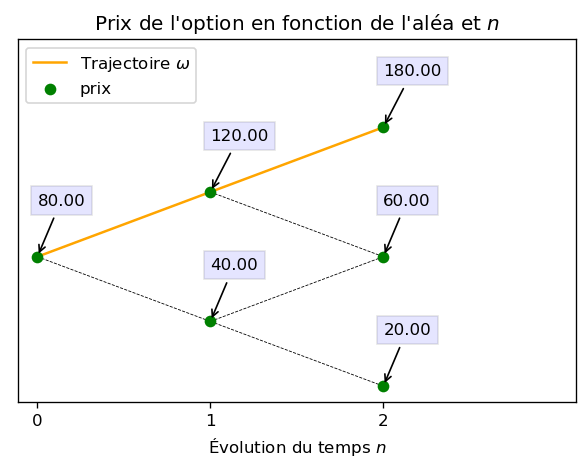

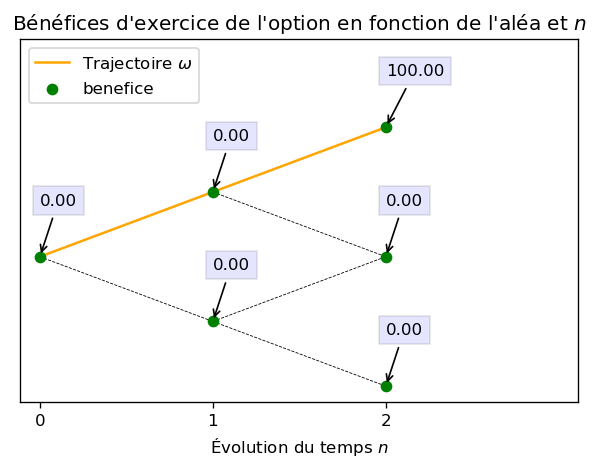

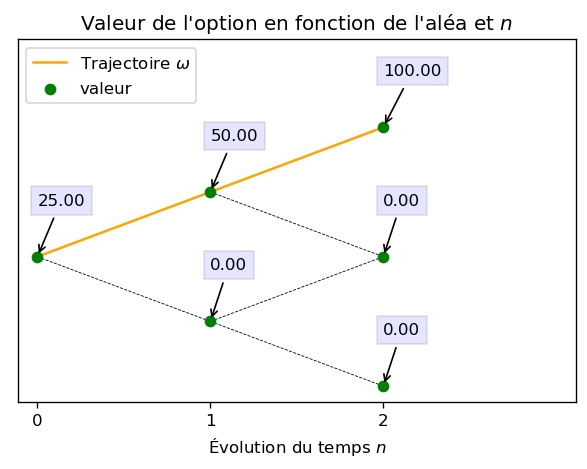

In [7]:
S0 = 80              #prix initial de l'actif risqué
K = 80              #prix d'exercice à l'échance 
down = -.5            #baisse du prix 
up = .5               #monté du prix 
intrest = 0         #taux d'interet fixe
N = 2                 #Echéance
call = True

option_euro = option_europeene(N=N, S0=S0, K=K, down=down, up=up , intrest=intrest, call=call)
option_euro.print_all( dpi = 100,graph=False)
option_euro.plot_all(dpi = 120, save= True, trajectoire = True)

La juste valeur de l'option au temps 0 est : 0.95€.

Arbre valeur :
[[ 0.94753633  0.          0.          0.          0.          0.        ]
 [ 3.24449304  0.24505318  0.          0.          0.          0.        ]
 [10.9         0.90895692  0.04008881  0.          0.          0.        ]
 [19.81        3.3125      0.16837302  0.          0.          0.        ]
 [27.829      11.791       0.70716667  0.          0.          0.        ]
 [35.0461     20.6119      2.9701      0.          0.          0.        ]]

---

Arbre prix :
[[110.       0.       0.       0.       0.       0.    ]
 [ 99.     121.       0.       0.       0.       0.    ]
 [ 89.1    108.9    133.1      0.       0.       0.    ]
 [ 80.19    98.01   119.79   146.41     0.       0.    ]
 [ 72.171   88.209  107.811  131.769  161.051    0.    ]
 [ 64.9539  79.3881  97.0299 118.5921 144.9459 177.1561]]

---

Arbre binaire :
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 1.

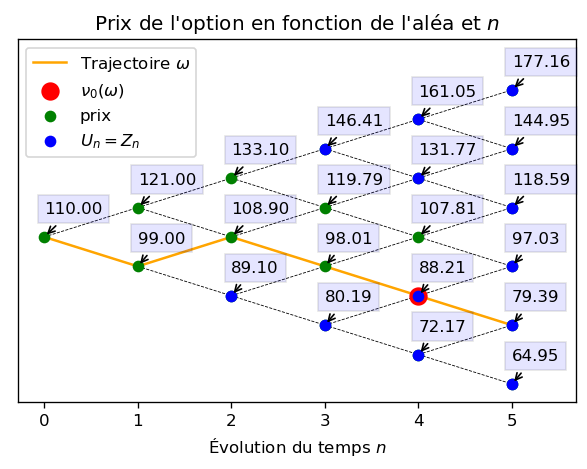

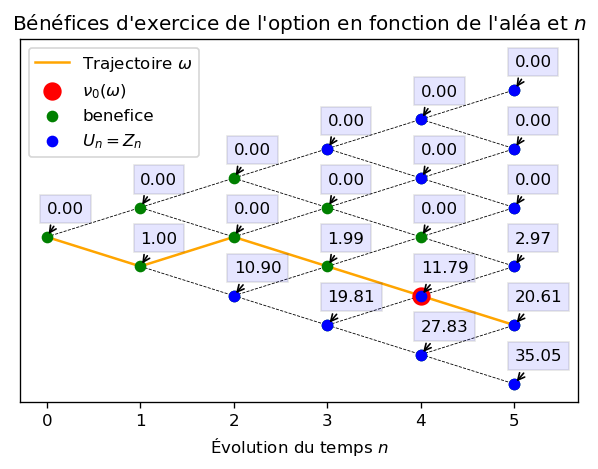

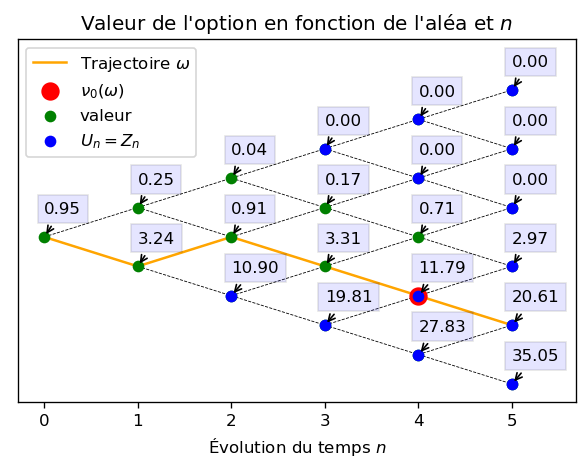

In [23]:
S0 = 110               #prix initial de l'actif risqué
K = 100                #prix d'exercice à l'échance 
down = -.1             #baisse du prix 
up = .1                #monté du prix 
intrest = 0.05          #taux d'interet fixe
N =   5                #Echéance
call = False

option_amer= option_americaine(N=N, S0=S0, K=K,down=down, up=up , intrest=intrest, call=call)
option_amer.print_all(graph =False)
option_amer.plot_all(trajectoire =True, dpi = 120, save = True)

In [56]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

print(bmatrix(option_amer.arbre_valeur))

\begin{bmatrix}
  0.94753633 & 0. & 0. & 0. & 0. & 0.\\
  3.24449304 & 0.24505318 & 0. & 0. & 0. & 0.\\
  10.9 & 0.90895692 & 0.04008881 & 0. & 0. & 0.\\
  19.81 & 3.3125 & 0.16837302 & 0. & 0. & 0.\\
  27.829 & 11.791 & 0.70716667 & 0. & 0. & 0.\\
  35.0461 & 20.6119 & 2.9701 & 0. & 0. & 0.\\
\end{bmatrix}
